# 像素值不是0-255？？？

In [1]:
import numpy as np
import scipy.io as sio
import random
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [2]:
#  https://blog.csdn.net/ljyljyok/article/details/107619881  这里是解决这个问题
# https://blog.csdn.net/weixin_44545603/article/details/103322446?utm_medium=distribute.pc_relevant.none-task-blog-OPENSEARCH-1.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-OPENSEARCH-1.nonecase
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path = os.path.join("E:\Eric_HSI\hyperspectral_datasets")
PaviaU = os.path.join(path,'paviaU.mat')
PaviaU_gt = os.path.join(path,'paviaU_gt.mat')
# 加载数据，返回值为一个字典内嵌ndarray的数据结构
data = sio.loadmat(PaviaU)
data_gt = sio.loadmat(PaviaU_gt)
data = data['data']  # im为样本点的光谱值的ndarray
data_label = data_gt['groundT']  # imGIS样本点的标签值组成的ndarray

In [4]:
# 归一化，这个归一化的方法有点不一样
data = (data - float(np.min(data)))
data = data/np.max(data)

In [5]:
path_train = r"E:\Eric_HSI\excise4\np_data\train" + ".npy"
path_train_label = r"E:\Eric_HSI\excise4\np_data\train_label" + ".npy"
path_test = r"E:\Eric_HSI\excise4\np_data\test" + ".npy"
path_test_label = r"E:\Eric_HSI\excise4\np_data\test_label" + ".npy"


train = np.load(path_train)
train_label = np.load(path_train_label)
test = np.load(path_test)
test_label = np.load(path_test_label)

In [6]:
# test_label = tf.keras.utils.to_categorical(test_label)
# train_label = tf.keras.utils.to_categorical(train_label)

In [7]:
train.shape, train_label.shape, test.shape, test_label.shape

((1800, 103, 1), (1800,), (40976, 103, 1), (40976,))

In [8]:
train.shape[1:]

(103, 1)

In [9]:
model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=(train.shape[1:]), return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
# model.add(layers.LSTM(64))
model.add(layers.Flatten())
model.add(layers.Dense(9, activation='softmax'))
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [10]:
# loss,acc = model.evaluate(train, train_label, verbose=2)

In [11]:
model.load_weights('./weights/weight.ckpt')
# loss,acc = model.evaluate(train, train_label, verbose=2)

In [12]:
# 构造一个类别数乘类别数的矩阵，输出结果为混淆矩阵
C = np.max(data_label)
matrix = np.zeros((C,C))
matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
len(train)

1800

In [14]:
# 对所有测试像素点进行预测
# 有三个 train 都需要改
for i in range(len(train)):
    # 增加一维然后进行预测
    # r = model.predict(test[i].reshape(-1,len(test[i])))   # r 为预测的结果，类别，1,2,3的数值ndarray
    r = np.argmax(model.predict(train[i].reshape(1, 103, 1)), axis=-1)
    # 构建混淆矩阵, 就是简单的加减法，预测到某个位置，某个位置的数值加 1
    matrix[r,train_label[i]] += 1

In [15]:
# 输出混淆矩阵
print('confusion matrix:')
print(matrix.astype(int))

confusion matrix:
[[137   0   9   0   0   1   6   1   0]
 [  2 141   1   8   0  43   0   1   0]
 [ 14   0 142   0   0   1   2  39   0]
 [  0  17   0 191   0   0   0   0   0]
 [  0   0   1   0 200   0   0   0   0]
 [  4  42   3   1   0 151   0   2   0]
 [ 40   0   3   0   0   0 192   0   0]
 [  3   0  41   0   0   4   0 157   0]
 [  0   0   0   0   0   0   0   0 200]]


In [16]:
# 每个类别的精度
ac_list = []
for i in range(len(matrix)):
    # 精度为混淆矩阵中预测正确即对角线中的个数除总数即一整列
    ac = matrix[i, i] / sum(matrix[:, i])
    ac_list.append(ac)
    print(i+1,'class:','(', matrix[i, i], '/', sum(matrix[:, i]), ')', ac)

1 class: ( 137.0 / 200.0 ) 0.685
2 class: ( 141.0 / 200.0 ) 0.705
3 class: ( 142.0 / 200.0 ) 0.71
4 class: ( 191.0 / 200.0 ) 0.955
5 class: ( 200.0 / 200.0 ) 1.0
6 class: ( 151.0 / 200.0 ) 0.755
7 class: ( 192.0 / 200.0 ) 0.96
8 class: ( 157.0 / 200.0 ) 0.785
9 class: ( 200.0 / 200.0 ) 1.0


In [17]:
# 输出总体精度
print('total right num:', np.sum(np.trace(matrix)))
print('total test num:',np.sum(matrix))
accuracy = np.sum(np.trace(matrix)) / np.sum(matrix)
print('Overall accuracy:', accuracy)

total right num: 1511.0
total test num: 1800.0
Overall accuracy: 0.8394444444444444


In [18]:
# 输出kappa 系数和平均精度
kk = 0
for i in range(matrix.shape[0]):
    kk += np.sum(matrix[i]) * np.sum(matrix[:, i])
pe = kk / (np.sum(matrix) * np.sum(matrix))
pa = np.trace(matrix) / np.sum(matrix)
kappa = (pa - pe) / (1 - pe)
ac_list = np.asarray(ac_list)
aa = np.mean(ac_list)
print('Average accuracy:',aa)
print('Kappa:', kappa)

Average accuracy: 0.8394444444444444
Kappa: 0.819375


In [19]:
img = np.zeros((data_label.shape[0],data_label.shape[1])).astype('int8')
img.dtype

dtype('int8')

In [20]:
k = 1000
iterarion = 0

In [21]:
# 绘图
# 输出的想的尺寸大小

# 在iG尺寸中填充像素的值
for i in range(data_label.shape[0]):
    for j in range(data_label.shape[1]):
        if data_label[i,j] == 0:
            continue
        else:
            prediction = np.argmax(model.predict(data[i, j].reshape(1, 103, 1)), axis=-1)
            img[i,j] = prediction + 1
            iterarion += 1
            if iterarion%k == 0:
                print('.', end='')

..........................................

In [22]:
# for i in range(100):
#     for j in range(100):
#         print(np.argmax(model.predict(data[i, j].reshape(1, 103, 1))))

In [23]:
import spectral

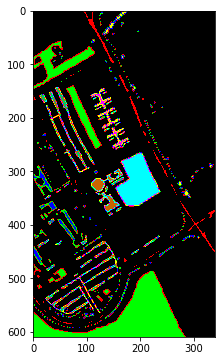

In [24]:
predict_image = spectral.imshow(classes=data_label, figsize=(6, 6))

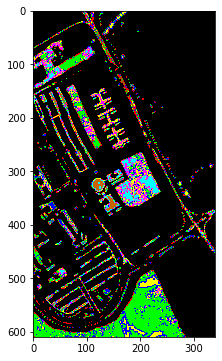

In [25]:
predict_image = spectral.imshow(classes=img, figsize=(6, 6))

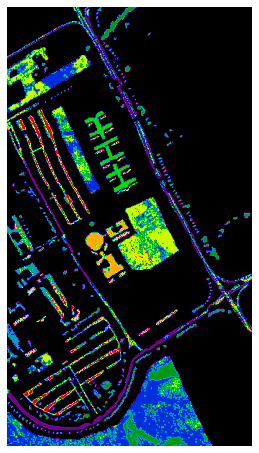

origin graph decode map get finished


In [31]:
# pcolor是用颜色图示数据，pcolor 实际上是画出一个个 grid，不同的数值有不同的grid

# de_map = img[::-1]  # 切片，获取从后向前排列的元素
de_map = img
fig, _ = plt.subplots()
height, width = de_map.shape
fig.set_size_inches(width/100.0, height/100.0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
plt.axis('off')
plt.axis('equal')
# plt.pcolor(de_map, cmap='nipy_spectral')
plt.imshow(de_map, cmap='nipy_spectral')
plt.savefig(os.path.join('result', 'decode_map1.png'),format='png',dpi=600)#bbox_inches='tight',pad_inches=0)
# plt.close()
plt.show()
print('origin graph decode map get finished')